<h1 align="center">ECE 176 Project</h1>

# Table of Contents

1. Dataset Preparation: we will implement an American Sign Language (ASL) alphabet library.
2. Model: create a neural network architecture for our dataset.
3. Finetuning: find ways to improve the model.
4. Test/Visuals: create tests and look at which ASL letters were best recognized and why.
5. Conclusion/Discussion: discussion of results and possible further study.



# Dataset Preparation

Initially, we will focus on implementing an American Sign Language (ASL) alphabet library. This involves loading the ASL alphabet dataset, a step that may require a few minutes upon the first attempt. Subsequently, the data will be cached, ensuring quicker access in future sessions. 


In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

import numpy as np

In [41]:

import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset  
from torchvision import transforms
from PIL import Image

class CustomImageDataset(Dataset):
    def __init__(self, img_dir, transform=None, target_transform=None, mode='train'):
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.mode = mode
        self.img_labels = self._get_image_labels()

    def _get_image_labels(self):
        img_labels = []
        if self.mode == 'train':
            label = 0
            for root, dirs, files in os.walk(self.img_dir):
                for subdir in sorted(dirs):
                    subdir_path = os.path.join(root, subdir)
                    for _, _, files in os.walk(subdir_path):
                        for file in files:
                            if file.lower().endswith(('png', 'jpg', 'jpeg')):
                                img_labels.append((os.path.join(subdir, file), label))
                    label += 1
        elif self.mode == 'test':
            for root, _, files in os.walk(self.img_dir):
                for file in files:
                    if file.lower().endswith(('png', 'jpg', 'jpeg')):
                        img_labels.append((file, None))
        return img_labels

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path, label = self.img_labels[idx]
        img_path = os.path.join(self.img_dir, img_path)
        image = Image.open(img_path).convert('RGB')  # Use PIL to open image
        if self.transform:
            image = self.transform(image)
        if self.target_transform and label is not None:
            label = self.target_transform(label)
        return image, label
    
class CustomTestImageDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.images = sorted(os.listdir(img_dir))  # Ensure the order is correct

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.images[idx])
        image = Image.open(img_path).convert('RGB')  # Use PIL to open and convert to RGB
        label = idx  # Assign label based on index, as mentioned
        if self.transform:
            image = self.transform(image)
        return image, label

In [51]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
])
train_dataset = CustomImageDataset(
    img_dir='/home/ybaglinbunod/private/archive/asl_alphabet_train/asl_alphabet_train', 
    transform=train_transform, 
    mode='train'
)
test_dataset = CustomTestImageDataset(
    img_dir='/home/ybaglinbunod/private/archive/asl_alphabet_test/asl_alphabet_test',  # Make sure to adjust this path
    transform=test_transform
)

In [59]:
#showing the training dataset
print(train_dataset.img_labels[0])
print(train_dataset.img_labels[3000])


('A/A2117.jpg', 0)
('B/B1749.jpg', 1)


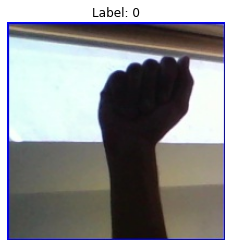

In [58]:
#showing the testing dataset
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

image, label = test_dataset[0]

image = transforms.ToPILImage()(image)
plt.imshow(image)
plt.title(f'Label: {label}')
plt.axis('off')  # This hides the axis ticks and labels
plt.show()





In [ ]:



NUM_TRAIN = 87000
batch_size = 64